# Radial Visualization of Semantic Embeddings

Loading GloVe model from local storage...
Preprocessing text...
Extracting embeddings...


[nltk_data] Downloading package punkt to /home/galen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


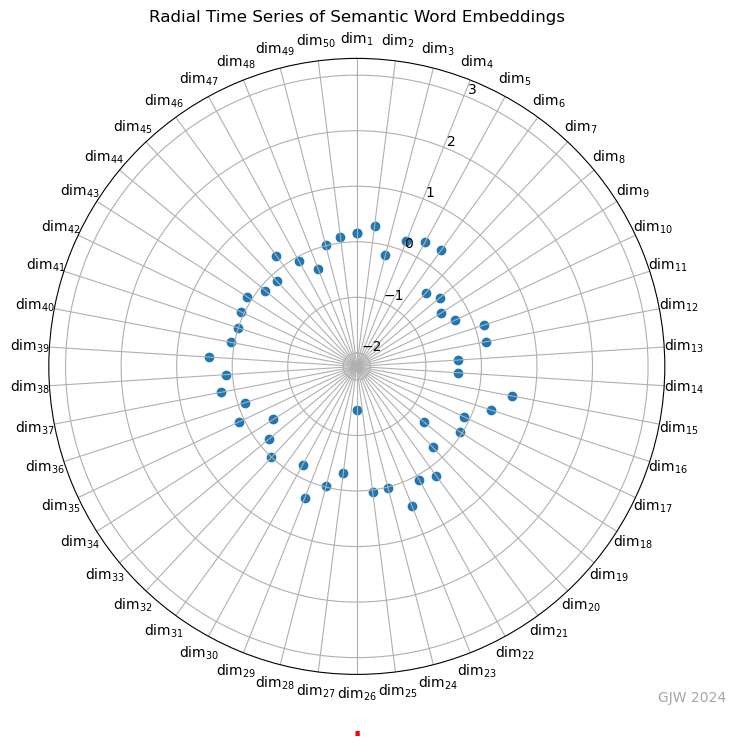

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import os
import gensim.downloader as api

def download_and_save_glove_model(model_name='glove-wiki-gigaword-50', download_dir=os.path.expanduser('~/Downloads/')):
    """
    Download and save GloVe model locally.
    
    Args:
        model_name (str): Name of the GloVe model to download.
        download_dir (str): Directory to save the downloaded model.
        
    Returns:
        model: GloVe model loaded using gensim.
    """
    model_path = os.path.join(download_dir, model_name)
    if not os.path.exists(model_path):
        print("Downloading GloVe model...")
        model = api.load(model_name)
        print("Saving GloVe model locally...")
        model.save(model_path)
    else:
        print("Loading GloVe model from local storage...")
        model = api.load(model_name)
    return model

def preprocess_text(text):
    """
    Tokenize sentences and words from the given text.
    
    Args:
        text (str): Input text.
        
    Returns:
        list: A list of tokenized sentences.
    """
    print("Preprocessing text...")
    nltk.download('punkt')
    sentences = sent_tokenize(text.lower())
    tokenized_sentences = [word_tokenize(sentence) for sentence in sentences]
    return tokenized_sentences

def extract_embeddings(tokenized_sentences, glove_model):
    """
    Extract word embeddings for each word in the tokenized sentences.
    
    Args:
        tokenized_sentences (list): List of tokenized sentences.
        glove_model (gensim model): GloVe embeddings model.
        
    Returns:
        np.ndarray: Array of word embeddings.
        list: List of words corresponding to the embeddings.
    """
    print("Extracting embeddings...")
    word_embeddings = []
    words = []
    for sentence in tokenized_sentences:
        for word in sentence:
            if word in glove_model:
                word_embeddings.append(glove_model[word])
                words.append(word)
    word_embeddings = np.array(word_embeddings)
    return word_embeddings, words

def normalize_embeddings(word_embeddings):
    """
    Normalize word embeddings to fit within the expected radial plot range.
    
    Args:
        word_embeddings (np.ndarray): Array of word embeddings.
        
    Returns:
        np.ndarray: Normalized word embeddings.
    """
    print("Normalizing embeddings...")
    return word_embeddings / np.linalg.norm(word_embeddings, axis=1, keepdims=True)

def update_plot(num, data, scatter, text_display, words):
    """
    Update the plot for the animation.
    
    Args:
        num (int): Frame number.
        data (list): Data to plot.
        scatter: Scatter plot object.
        text_display: Text object for displaying the word.
        words (list): List of words to display.
        
    Returns:
        tuple: Updated scatter and text objects.
    """
    scatter.set_offsets(np.c_[angles, data[num]])
    text_display.set_text(words[num])
    return scatter, text_display

def create_radial_animation(word_embeddings, words, output_path='radial_animation.gif'):
    """
    Create a radial animation of word embeddings.
    
    Args:
        word_embeddings (np.ndarray): Array of word embeddings.
        words (list): List of words corresponding to the embeddings.
        output_path (str): Path to save the output GIF.
    """
    num_points = len(word_embeddings)
    num_dimensions = word_embeddings.shape[1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)

    data = []
    for i in range(num_points):
        values = word_embeddings[i].tolist()
        values += values[:1]
        data.append(values)
    
    scatter = ax.scatter(angles, data[0])
    text_display = ax.text(0.5, -0.1, '', transform=ax.transAxes, ha='center', fontsize=30, color='red')
    
    # Add GJW 2024 text
    ax.text(1.1, -.05, 'GJW 2024', transform=ax.transAxes, ha='right', va='bottom', fontsize=10, color='grey', alpha=0.7)
    
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(interpretable_axes)
    
    plt.title('Radial Time Series of Semantic Word Embeddings')

    ani = animation.FuncAnimation(fig, update_plot, frames=num_points, fargs=(data, scatter, text_display, words), interval=500, blit=True)
    ani.save(output_path, writer='pillow')
    
def main():
    # Sample text
    text = "Once upon a time, there was a little girl who lived in a village near the forest. Whenever she went out, the little girl wore a red riding cloak, so everyone in the village called her Little Red Riding Hood."

    # Load GloVe model
    glove_model = download_and_save_glove_model()

    # Preprocess text
    tokenized_sentences = preprocess_text(text)

    # Extract embeddings
    word_embeddings, words = extract_embeddings(tokenized_sentences, glove_model)

    # Human-interpretable axes
    global angles, interpretable_axes
#     interpretable_axes = [f'dim_{i+1}' for i in range(word_embeddings.shape[1])]
    interpretable_axes = [f'$\\mathrm{{dim}}_{{{i+1}}}$' for i in range(word_embeddings.shape[1])]

    angles = np.linspace(0, 2 * np.pi, len(interpretable_axes), endpoint=False).tolist()
    angles += angles[:1]

    # Generate the animation
    create_radial_animation(word_embeddings, words)

if __name__ == "__main__":
    main()
